In [1]:
#Importing required packages
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import linregress
from scipy.signal import savgol_filter
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
#Loading the data file
#lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211111_v1_level2.lc')
lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211013_v1_level2.lc')

In [3]:
lc.info()
#Information about data contained in the lc file

Filename: C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211013_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   80554R x 4C   [D, E, E, E]   


In [4]:
#Header of lc file primary
lc[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
MISSION = 'CHANDRAYAAN-2'      / Name of mission/satellite                      
TELESCOP= 'CH-2_ORBITER'       / Name of mission/satellite                      
INSTRUME= 'CH2_XSM '           / Name of Instrument/detector                    
ORIGIN  = 'PRLPOC  '           / Source of FITS file                            
CREATOR = 'xsmgenlc '          / Creator of file                                
FILENAME= 'ch2_xsm_20211013_v1_level2.lc' / Name of file                        
CONTENT = 'Light curve'     

In [5]:
#Header of lc file rate
lc[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                80554 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'ERROR   '        

Text(0, 0.5, 'Counts')

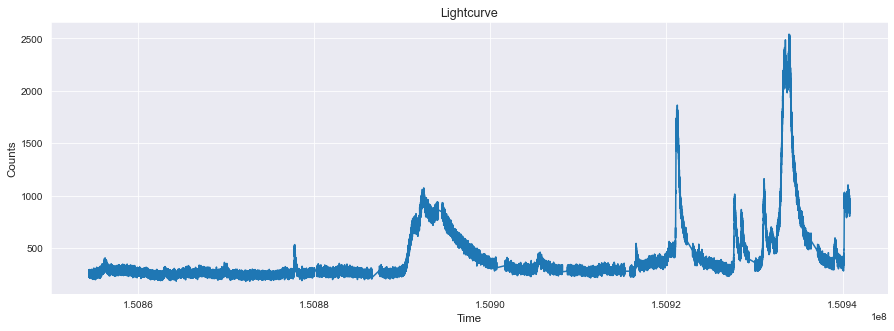

In [6]:
#Extracting count rates and time from the lc file
count_rate = lc['Rate'].data['Rate']
time = lc['Rate'].data['Time']
count_rate, time = np.array(count_rate), np.array(time)
plt.figure(0, figsize=(15,5))
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Counts',fontsize = 11.5)

Text(0, 0.5, 'Background subtracted counts')

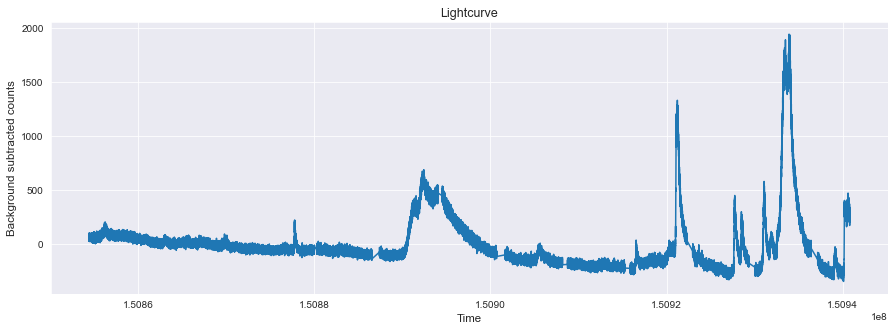

In [7]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(time, count_rate)
#bksub_counts = count_rate - np.array(slope*time+intercept)
count_rate = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
#plt.plot(time, bksub_counts)
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0, 0.5, 'Boxcar smoothed counts')

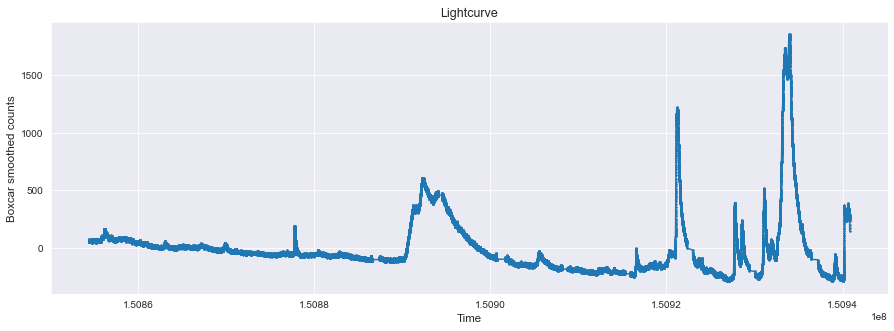

In [10]:
#box_car averaging
box_bin = 70
kernel_size = 8
box_time, box_count = np.array([]), np.array([])
for i in range(len(time[:])//box_bin):
    print(i)
    if(box_bin*i+i<=len(count_rate)):
        counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
        boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
        box_count = np.concatenate((box_count, boxavg_counts))
        box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
        #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
    else:
        continue
plt.figure(0, figsize=(15,5))
plt.plot(box_time, box_count, marker = '.', markersize = 3)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Boxcar smoothed counts',fontsize = 11.5)

In [ ]:
binned_time, binned_count = np.array([]), np.array([])
bin = 70
for i in range(len(box_time)//bin):
    binned_time = np.concatenate((binned_time, [(box_time[bin*i]+box_time[bin*(i+1)])/2]))
    binned_count = np.concatenate((binned_count, [np.average(box_count[bin*i:bin*(i+1)])]))
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, binned_count, marker = '.', markersize = 4)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Binned counts',fontsize = 11.5)

In [ ]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-20:])
st_flags = np.where(np.divide(st_nr, st_dr)>st_cutoff)
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

#Peak of burst
peak = binned_count[st_flags[0][0]:]
pk_nr = peak[4:]
pk_dr = peak[:-4]
peak_flags = st_flags[0][0]+np.where(np.divide(pk_nr, pk_dr)<1)
print(peak_flags[0][0])

#End of burst
#zero_crossings = peak_flags[0][0]+np.where(np.where(np.diff(np.sign(np.divide(pk_nr, pk_dr)-1)))[0]>peak_flags[0][0])
#print(zero_crossings[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = 'o')

for i in range(min(len(st_flags[0]), len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')
    plt.axvline(binned_time[peak_flags[0][i]], color = 'black', ls='--')
#plt.axvline(binned_time[zero_crossings[0][10]], color = 'red', ls='--')

In [ ]:
print(np.ediff1d(st_flags[0]))

In [ ]:
print(st_flags)

3.2806389579381543
329


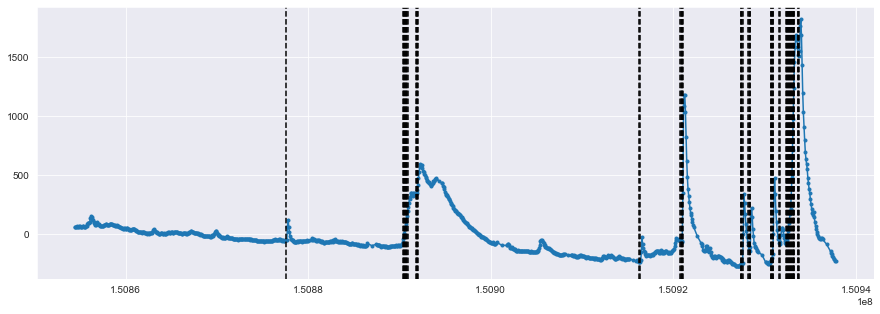

In [53]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_nr = st_nr - st_dr
st_dr = binned_time[4:] - binned_time[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-200:])
st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(min(len(st_flags[0]), len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')

In [16]:
diff = np.ediff1d(st_flags[0])
diff

array([168,   1,   1,   1,   1,   1,   1,   1,  13,   1,   1,   1, 310,
         1,  63,   1,   1,   1,   1,  81,   1,   1,   1,   9,   1,   1,
         1,  22,   1,   1,   1,   1,   9,   1,  10,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1],
      dtype=int64)

In [19]:
np.where(diff<5)

(array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 15, 16, 17, 18, 20, 21,
        22, 24, 25, 26, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 49, 50], dtype=int64),)

In [20]:
fits = fits.open(r'C:\Users\aswin\OneDrive\Desktop\go1320160101.fits')

In [21]:
fits.info()

Filename: C:\Users\aswin\OneDrive\Desktop\go1320160101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   ()      
  1  EDGES         1 BinTableHDU     18   1R x 1C   [4E]   
  2  FLUXES        1 BinTableHDU     32   1R x 2C   [42185D, 84370E]   
  3  STATUS        1 BinTableHDU     30   1R x 2C   [1E, 2E]   


ValueError: x and y must have same first dimension, but have shapes (42185,) and (2,)

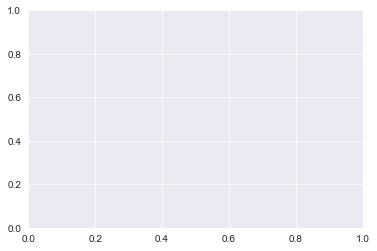

In [32]:
plt.plot(fits[2].data['Time'][0], fits[2].data['Flux'][0][0])

In [37]:
fits[2].data['Flux'][:][0]

array([[4.0562e-07, 5.6633e-09],
       [4.0562e-07, 6.2091e-09],
       [4.0562e-07, 5.6633e-09],
       ...,
       [2.2339e-05, 2.4929e-06],
       [2.2339e-05, 2.4929e-06],
       [2.2353e-05, 2.4950e-06]], dtype=float32)

In [33]:
fits[2].header

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Jan  6 15:15:38 2016       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =               674960 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    2 /Number of columns                               
MJDREF  =                43874 /MJD for reference file                          
TIMESYS = 'MJD     '           /The time system is MJD                          
TIMEUNIT= 's       '           /Unit for TSTART and TSTOP                       
TIMEZERO=                57388 /Time zero off-set                               
TSTART  =       -1.440999984

In [9]:
for i in range(len(time[:])//box_bin):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
i = 1139
box_bin = 70
kernel_size = 8
box_count = np.array([])
box_time = np.array([])
counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
print(counts, box_bin*i)
#plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
#plt.plot(box_time[box_bin*i:box_bin*(i+1)+kernel_size+1], box_count[box_bin*i:box_bin*(i+1)+kernel_size+1], marker = '.', markersize = 3)

[] 79730


In [ ]:
boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]

In [ ]:
box_count = np.concatenate((box_count, boxavg_counts))
box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))

In [10]:
print(len(count_rate))

80554


In [ ]:
convolve([], Box1DKernel(8))

In [12]:
def smooth(binsize = 70, kernelsize = 8):
    box_bin = binsize
    kernel_size = kernelsize
    box_time, box_count = np.array([]), np.array([])
    for i in range(len(time[:])//box_bin):
        print(i)
        if(box_bin*i+i<=len(count_rate)):
            counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
            boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
            box_count = np.concatenate((box_count, boxavg_counts))
            box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
            #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
        else:
            continue
    return box_time, box_count